In [1]:
import time, psutil, os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [2]:
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
!pip install num2words
from num2words import num2words
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import scipy
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, ParameterGrid

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import json
import gensim
from sklearn.decomposition import TruncatedSVD

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/My Drive/

/content/drive/My Drive


In [31]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,category,sub_category,crimeaditionalinfo
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I had continue received random calls and abusi...
1,Online Financial Fraud,Fraud CallVishing,The above fraudster is continuously messaging ...
2,Online Gambling Betting,Online Gambling Betting,He is acting like a police and demanding for m...
3,Online and Social Media Related Crime,Online Job Fraud,In apna Job I have applied for job interview f...
4,Online Financial Fraud,Fraud CallVishing,I received a call from lady stating that she w...


In [32]:
synthetic_train_df = pd.read_csv("synthetic_train.csv")

df = pd.concat([train_df, synthetic_train_df], axis=0)

In [33]:
from collections import defaultdict
category_to_subcategory_map = defaultdict(set)

In [34]:
for index, row in df.iterrows():
  category = row.category
  subcategory = row.sub_category

  category_to_subcategory_map[category].add(subcategory)

In [35]:
category_count = defaultdict(int)
subcategory_count = defaultdict(int)

for index, row in df.iterrows():
  category = row.category
  subcategory = row.sub_category

  category_count[category] += 1
  subcategory_count[subcategory] += 1

In [38]:
df.columns

Index(['category', 'sub_category', 'crimeaditionalinfo'], dtype='object')

In [37]:
df = df.drop('Unnamed: 0', axis=1)

In [39]:
df = df[df['category'].notna()]
df = df[df['crimeaditionalinfo'].notna()]
df.drop_duplicates(inplace = True) # Dropping duplicate observations
df = df.sample(frac=1)

In [40]:
len(df)

86547

In [41]:
categories = df.category.values
messages = df.crimeaditionalinfo.values
subcategories = df.sub_category.values

In [42]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

labels = list(categories)
categories_encoded = label_encoder.fit_transform(labels)

In [43]:
df["categories_encoded"] = categories_encoded

## Visualisations

In [ ]:
values = np.array(list(category_count.values()))
labels = list(category_count.keys())
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of category frequencies"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95))
fig.show()

<Axes: xlabel='crimeaditionalinfo', ylabel='Count'>

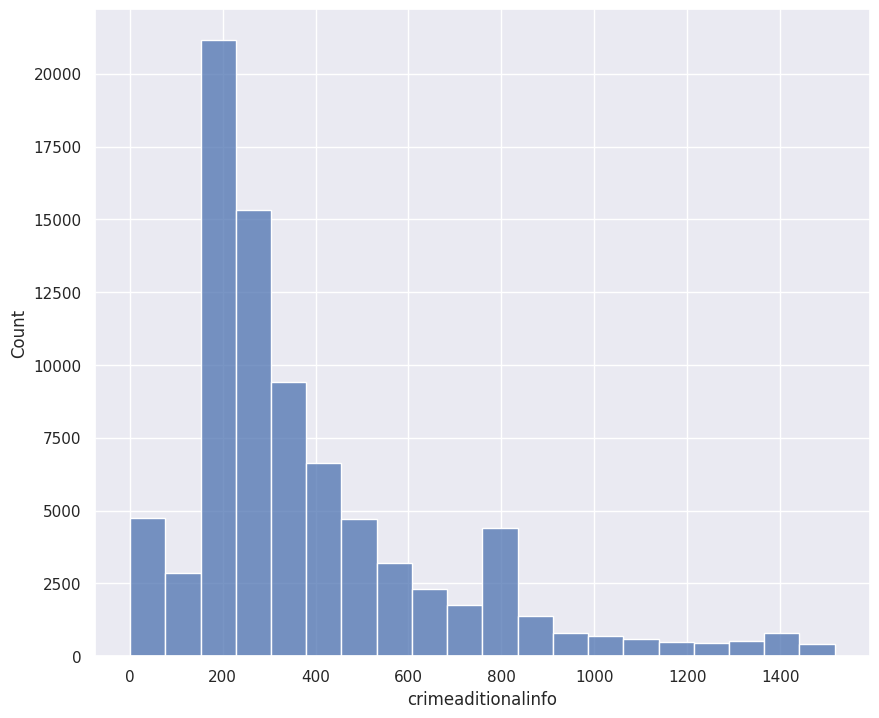

In [ ]:
df_char = df['crimeaditionalinfo'].str.len()

fig, ax = plt.subplots(1, 1, figsize = (10, 8.4), sharey = False)
sns.histplot(x = df_char, bins = 20)

<Axes: xlabel='crimeaditionalinfo', ylabel='Count'>

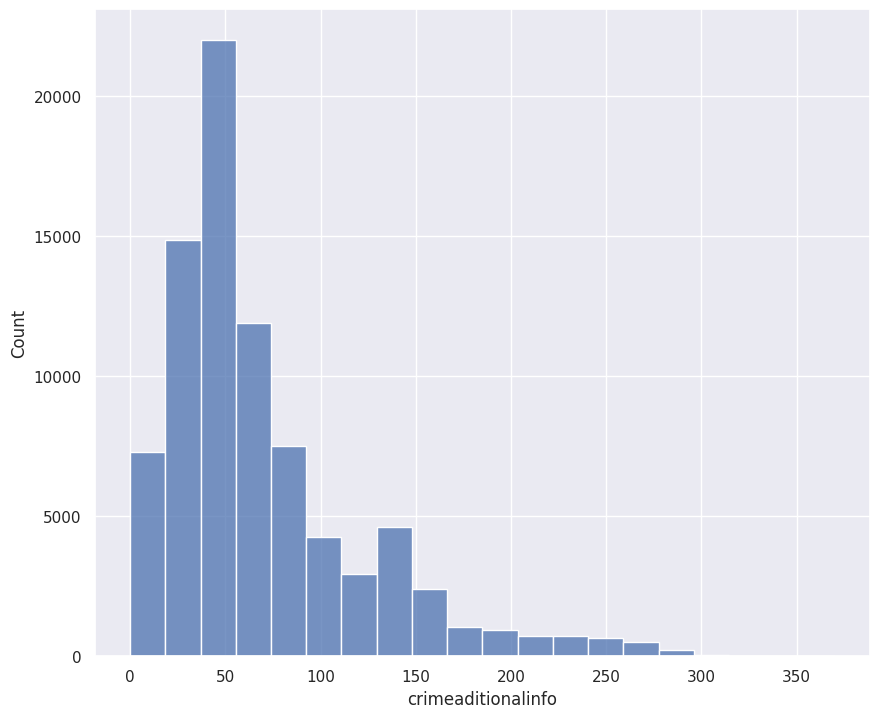

In [ ]:
df_word = df['crimeaditionalinfo'].str.split().map(lambda x: len(x))

fig, ax = plt.subplots(1, 1, figsize = (10, 8.4), sharey = False)
sns.histplot(x = df_word, bins = 20)

In [ ]:
df.head()

,category,sub_category,crimeaditionalinfo,categories_encoded
82013,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,Respected SirMadamI am Saikat Kumar Singha fro...,8
26495,Online and Social Media Related Crime,FakeImpersonating Profile,facebook id ...,8
63906,Online Financial Fraud,DebitCredit Card FraudSim Swap Fraud,online froud,6
89780,Online Financial Fraud,UPI Related Frauds,I got a call from Aniket which was a false nam...,6
2530,Hacking Damage to computercomputer system etc,Unauthorised AccessData Breach,Pending dikhte dikhte payment dal diye process...,4


## Train Validation Split

In [44]:
X, y = df["crimeaditionalinfo"], df["categories_encoded"]

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 40)
df_train = pd.concat([X_train, y_train], axis = 1)

In [45]:
df_val = pd.concat([X_val, y_val], axis = 1)

## Text Preprocessing

In [46]:
regexp = RegexpTokenizer("[\w']+")

In [47]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [22]:
# Utility functions for text preprocessing

def convert_to_lowercase(text):
    return text.lower()

def remove_whitespace(text):
    return text.strip()

def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "")
    return text.translate(str.maketrans("", "", punct_str))

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

acronyms_url = 'english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')
acronyms_list = list(acronyms_dict.keys())

def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

contractions_url = 'english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')
contractions_list = list(contractions_dict.keys())

def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

stops = stopwords.words("english")
stops_1 = stopwords.words("hinglish")
allstops = stops + stops_1

def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem


spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    return text_spacy

def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

In [23]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text)
    text = re.sub('\[.*?\]', '', text)
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
    text = text_lemmatizer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    return text

In [48]:
df_train_norm, df_val_norm = pd.DataFrame(), pd.DataFrame()

df_train_norm['message'] = df_train['crimeaditionalinfo'].apply(text_normalizer)
df_val_norm['message'] = df_val['crimeaditionalinfo'].apply(text_normalizer)

df_train_norm['label'] = df_train['categories_encoded']
df_val_norm['label'] = df_val['categories_encoded']

## Text Vectorization

In [49]:
X_train_norm, y_train = df_train_norm['message'].tolist(), df_train_norm['label'].tolist()
X_val_norm, y_val = df_val_norm['message'].tolist(), df_val_norm['label'].tolist()

In [50]:
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
X_train_tfidf = TfidfVec.fit_transform(X_train_norm)
X_val_tfidf = TfidfVec.transform(X_val_norm)

## Baseline Models

In [ ]:
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = 60, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
    SGDClassifier(loss = 'hinge'),
    RidgeClassifier(),
    XGBClassifier(),
    AdaBoostClassifier()
]

In [ ]:
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(f1_score(y_train, y_train_pred, average='micro'))
        score_val.append(f1_score(y_val, y_val_pred, average='micro'))

    score_df["Classifier"], score_df["Training F1 score"], score_df["Validation F1 score"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation F1 score', ascending = False, inplace = True)
    return score_df

In [ ]:
score(X_train_tfidf, y_train, X_val_tfidf, y_val, names = names, models = models)

## SVM

In [51]:
svm_classifier = svm.SVC()
params_svm = {
    'kernel': ['linear', 'rbf'],
    'C': [1, 10, 100]
}

In [ ]:
best_model_svm, best_params_svm, best_score_svm, count = svm_classifier, ParameterGrid(params_svm)[0], 0, 0


for g in ParameterGrid(params_svm):
    time_start = time.time()
    count += 1
    print(f"Gridpoint #{count}: {g}")
    svm_classifier.set_params(**g)
    svm_classifier.fit(X_train_tfidf, y_train)
    y_train_pred, y_val_pred = svm_classifier.predict(X_train_tfidf), svm_classifier.predict(X_val_tfidf)
    score_train, score_val = f1_score(y_train, y_train_pred, average='micro'), f1_score(y_val, y_val_pred, average='micro')
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    print(" ")
    if score_val > best_score_svm:
        best_params_svm, best_score_svm = g, score_val

Gridpoint #1: {'C': 1, 'kernel': 'linear'}
Training accuracy: 0.8321973516165894, Validation accuracy: 0.7652752571082879, Runtime: 49m15s
 
Gridpoint #2: {'C': 1, 'kernel': 'rbf'}


## Testing

In [53]:
len(list(label_encoder.classes_))

15

['Cryptocurrency Crime',
 'Child Pornography CPChild Sexual Abuse Material CSAM',
 'Crime Against Women & Children',
 'Sexually Obscene material',
 'Cyber Terrorism',
 'Hacking  Damage to computercomputer system etc',
 'Any Other Cyber Crime',
 'Online and Social Media Related Crime',
 'Online Gambling  Betting',
 'Ransomware',
 'Online Cyber Trafficking',
 'Sexually Explicit Act',
 'Cyber Attack/ Dependent Crimes',
 'Online Financial Fraud',
 'RapeGang Rape RGRSexually Abusive Content']

In [58]:
df_test = pd.read_csv("test.csv")

df_test = df_test[df_test['category'].notna()]
df_test = df_test[df_test['crimeaditionalinfo'].notna()]

df_test = df_test[df_test['category'] != 'Crime Against Women & Children']

categories = df_test.category.values
messages = df_test.crimeaditionalinfo.values

categories_encoded = label_encoder.transform(list(categories))


df_test_norm = pd.DataFrame()

df_test_norm['message'] = df_test['crimeaditionalinfo'].apply(text_normalizer)

KeyError: 'categories_encoded'

In [60]:
df_test["categories_encoded"] = categories_encoded

In [61]:
df_test_norm['label'] = df_test['categories_encoded']


X_test_norm, y_test = df_test_norm['message'].tolist(), df_test_norm['label'].tolist()
X_test_tfidf = TfidfVec.transform(X_test_norm)

In [ ]:
svm_classifier = svm.SVC(C=1.0, kernel='rbf')
svm_classifier.fit(X_train_tfidf, y_train)

y_test_pred = svm_classifier.predict(X_test_tfidf)

In [ ]:
f1 = f1_score(list(categories_encoded), y_test_pred, average='micro')